               Mean       1       2       3       4       5       6       7  \
TP          1396.20 1404.00 1376.00 1406.00 1397.00 1396.00 1381.00 1400.00   
TN           440.90  446.00  425.00  439.00  441.00  432.00  454.00  437.00   
FP           119.60  114.00  135.00  121.00  120.00  129.00  107.00  124.00   
FN           119.10  112.00  140.00  110.00  118.00  119.00  134.00  115.00   
P           1515.30 1516.00 1516.00 1516.00 1515.00 1515.00 1515.00 1515.00   
N            560.50  560.00  560.00  560.00  561.00  561.00  561.00  561.00   
TPR            0.92    0.93    0.91    0.93    0.92    0.92    0.91    0.92   
TNR            0.79    0.80    0.76    0.78    0.79    0.77    0.81    0.78   
FPR            0.21    0.20    0.24    0.22    0.21    0.23    0.19    0.22   
FNR            0.08    0.07    0.09    0.07    0.08    0.08    0.09    0.08   
Recall         0.92    0.93    0.91    0.93    0.92    0.92    0.91    0.92   
Precision      0.92    0.92    0.91    0.92    0.92 

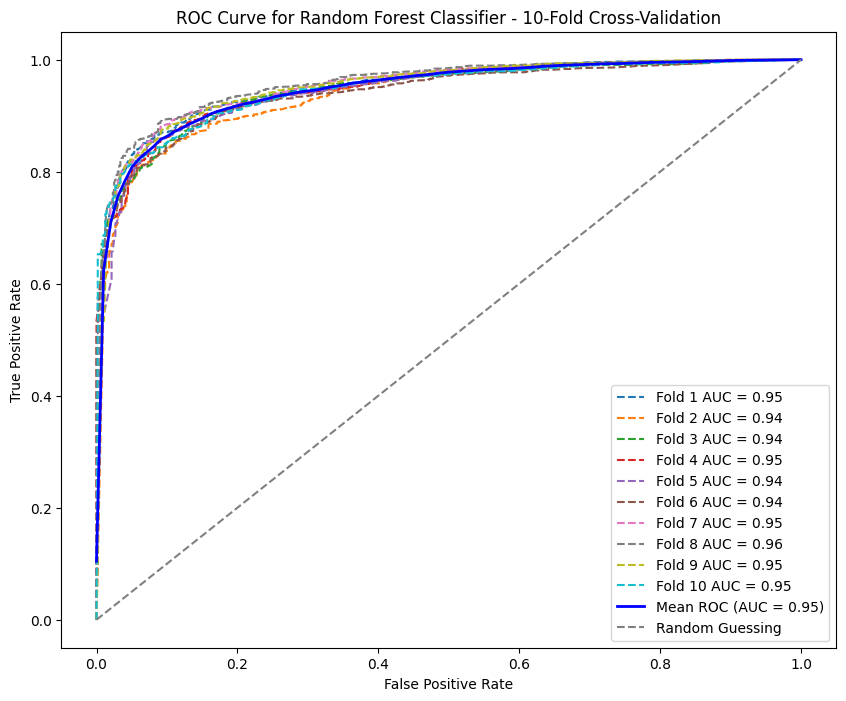

In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, brier_score_loss, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("C:/Users/15514/OneDrive/Documents/Fall 2024/playground-series-s4e2/train_cleaned.csv")

# Preprocess the data (encode categorical variables)
df_encoded = pd.get_dummies(df, columns=['gender', 'family_history_overweight', 'freq_high_cal_food', 
                                         'alch_in_excess', 'smoker', 'calorie_monitor', 
                                         'alch_consump', 'mode_of_trans'])

# Convert target column to binary values (e.g., 'Normal' -> 0, 'Overweight' -> 1)
df_encoded['label'] = df_encoded['label'].apply(lambda x: 1 if x == 'Overweight' else 0)

# Define features (X) and target (y)
X = df_encoded.drop(columns=['id', 'label', 'label_cat', 'height', 'weight'])
y = df_encoded['label']

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform 10-fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists for each metric to store values for each fold
fold_metrics = {
    'TP': [], 'TN': [], 'FP': [], 'FN': [], 'P': [], 'N': [],
    'TPR': [], 'TNR': [], 'FPR': [], 'FNR': [],
    'Recall': [], 'Precision': [], 'F1 Score': [],
    'Accuracy': [], 'Error Rate': [], 'BACC': [],
    'TSS': [], 'HSS': [],
    'Brier Score': [], 'AUC': []
}

# For ROC curve
tpr_list = []  # To store true positive rates for each fold
fpr_list = []  # To store false positive rates for each fold
auc_scores = []  # To store AUC scores for each fold

for train_index, test_index in kf.split(X, y):
    # Split data into train and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the Random Forest model
    rf_model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = rf_model.predict(X_test)
    y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # Probability for positive class
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    # Calculate the number of positives and negatives
    P = TP + FN  # Total positives
    N = TN + FP  # Total negatives
    
    # Calculate metrics
    TPR = TP / P if P != 0 else 0  # Sensitivity/Recall
    TNR = TN / N if N != 0 else 0  # Specificity
    FPR = FP / N if N != 0 else 0  # False Positive Rate
    FNR = FN / P if P != 0 else 0  # False Negative Rate
    recall = TPR
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    accuracy = (TP + TN) / (P + N)
    error_rate = 1 - accuracy
    brier = brier_score_loss(y_test, y_pred_prob)
    auc_score = roc_auc_score(y_test, y_pred_prob)
    bacc = (TPR + TNR) / 2  # Balanced Accuracy
    tss = TPR - FPR  # True Skill Statistic
    hss = (2 * (TP * TN - FP * FN)) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN)) if ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN)) != 0 else 0
    
    # Store metrics for this fold
    fold_metrics['TP'].append(TP)
    fold_metrics['TN'].append(TN)
    fold_metrics['FP'].append(FP)
    fold_metrics['FN'].append(FN)
    fold_metrics['P'].append(P)
    fold_metrics['N'].append(N)
    fold_metrics['TPR'].append(TPR)
    fold_metrics['TNR'].append(TNR)
    fold_metrics['FPR'].append(FPR)
    fold_metrics['FNR'].append(FNR)
    fold_metrics['Recall'].append(recall)
    fold_metrics['Precision'].append(precision)
    fold_metrics['F1 Score'].append(f1)
    fold_metrics['Accuracy'].append(accuracy)
    fold_metrics['Error Rate'].append(error_rate)
    fold_metrics['BACC'].append(bacc)
    fold_metrics['TSS'].append(tss)
    fold_metrics['HSS'].append(hss)
    fold_metrics['Brier Score'].append(brier)
    fold_metrics['AUC'].append(auc_score)
    
    # Store ROC data for this fold
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_scores.append(auc_score)

# Calculate mean values for each metric
mean_values = {metric: [np.mean(values)] for metric, values in fold_metrics.items()}

# Add the mean values at the start of the DataFrame
fold_metrics_df = pd.DataFrame(mean_values).T
fold_metrics_df.columns = ['Mean']
fold_metrics_df = pd.concat([fold_metrics_df, pd.DataFrame(fold_metrics).T], axis=1)
fold_metrics_df.columns = ['Mean'] + [f'{i+1}' for i in range(10)]


# Display the DataFrame without .style
print(fold_metrics_df)

# Plot the ROC curves for each fold
plt.figure(figsize=(10, 8))
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], linestyle='--', label=f'Fold {i+1} AUC = {auc_scores[i]:.2f}')

# Calculate and plot mean ROC curve
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr_list[i], tpr_list[i]) for i in range(len(tpr_list))], axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier - 10-Fold Cross-Validation')
plt.legend(loc='lower right')
plt.show()
